In [1]:
import sys
import xarray as xr
import torch
import random
import numpy as np
import torchinfo
import importlib as imp
import pandas as pd
import warnings
import pickle

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib as mpl
import cartopy as ct
import cmasher as cmr

import utils
import datamaker.data_loader as data_loader
from datamaker.data_generator import ClimateData
import datamaker.regions as regions
from trainer.trainer import Trainer
from model.model import TorchModel
import model.loss as module_loss
import model.metric as module_metric
import visuals.plots as plots
from shash.shash_torch import Shash

print(f"python version = {sys.version}")
print(f"numpy version = {np.__version__}")
print(f"xarray version = {xr.__version__}")
print(f"pytorch version = {torch.__version__}")

# TODO: Further edit the README
# TODO: Add data loading structure to template.

python version = 3.12.0 | packaged by conda-forge | (main, Oct  3 2023, 08:36:57) [Clang 15.0.7 ]
numpy version = 1.26.4
xarray version = 2024.1.1
pytorch version = 2.1.2.post2


In [2]:
# load observations

config = utils.get_config("exp403")
seed = config["seed_list"][0]
device = utils.prepare_device(config["device"])

data_plot = ClimateData(
    config["datamaker"],
    expname=config["expname"],
    seed=seed,
    data_dir=config["data_dir"],
    figure_dir=config["figure_dir"],
    fetch=False,
    verbose=False,
)

In [3]:
LOSS_THRESHOLD = -0.1
exp_list = (
    "exp401",
    "exp402",
    "exp403",
    "exp001",
    "exp002",
    "exp003",
    "exp004",
    "exp005",
    "exp006",
    "exp007",
    "exp008",
    "exp009",
    "exp010",
    "exp080",
    "exp081",
)
# exp_list = (
#     "exp004",
#     "exp011",
#     "exp012",
#     "exp003",
#     "exp403",
#     "exp005",
#     "exp016",
#     "exp017",
#     "exp018",
#     "exp406",
#     "exp405",
# )

# load the models
# ------------------------------------
df_metrics = pd.DataFrame()
for parent_exp_name in exp_list:

    config = utils.get_config(parent_exp_name)

    for seed in config["seed_list"]:

        model_name = utils.get_model_name(config["expname"], seed)

        # get base model metrics
        try:
            df = pd.read_pickle(config["output_dir"] + model_name + "_metrics.pickle")
        except:
            continue

        # load the model
        model = TorchModel(
            config=config["arch"],
            target_mean=df["target_mean"][0],
            target_std=df["target_std"][0],
        )
        model = utils.load_torch_model(model, config["model_dir"] + model_name + ".pt")
        # model.to(device)

        # get obs data and make predictions
        data_plot.fetch_obs(ssp="ssp119", verbose=False)
        output = model.predict(
            dataset=data_loader.CustomData(data_plot.d_obs),
            batch_size=128,
            device=device,
        )
        del model

        dict_df = {}
        dict_df["exp_name"] = parent_exp_name
        dict_df["rng_seed"] = seed

        dict_df["loss_test"] = df["loss_test"][0]
        dict_df["error_test"] = df["error_test"][0]
        dict_df["d_test"] = df["d_test"][0]

        dict_df["loss_val"] = df["loss_val"][0]
        dict_df["error_val"] = df["error_val"][0]
        dict_df["d_val"] = df["d_val"][0]

        dict_df["d_valtest"] = df["d_valtest"][0]

        dict_df["obs_2023_mean"] = (
            Shash(output).mean().numpy()[-1] + data_plot.d_obs["current_temp"][-1]
        )
        dict_df["obs_2023_width"] = (
            Shash(output).quantile(1.0 - 1.0 / 6.0).numpy()
            - Shash(output).quantile(1.0 / 6.0).numpy()
        )[-1]

        # -----------------------------------------------
        # LOAD EVERYTHING INTO THE MAIN DATAFRAME
        df_metrics = pd.concat([df_metrics, pd.DataFrame(dict_df, index=[0])])

df_metrics_loss = df_metrics[df_metrics["loss_test"] >= LOSS_THRESHOLD]
df_metrics = df_metrics[df_metrics["loss_test"] < LOSS_THRESHOLD]
# df_metrics_loss = df_metrics
df_metrics.replace([np.inf, -np.inf], np.nan, inplace=True)
df_metrics = df_metrics.reset_index(
    drop=True,
)
df_metrics_loss = df_metrics_loss.reset_index(
    drop=True,
)
# df_metrics

# Make the Plots

<>:123: SyntaxWarning: invalid escape sequence '\c'
<>:152: SyntaxWarning: invalid escape sequence '\c'
<>:180: SyntaxWarning: invalid escape sequence '\c'
<>:123: SyntaxWarning: invalid escape sequence '\c'
<>:152: SyntaxWarning: invalid escape sequence '\c'
<>:180: SyntaxWarning: invalid escape sequence '\c'
/var/folders/sw/7glfsp2j5w3cw43s572xlj9r0000gn/T/ipykernel_19043/3057698387.py:123: SyntaxWarning: invalid escape sequence '\c'
  marker="$\circ$",
/var/folders/sw/7glfsp2j5w3cw43s572xlj9r0000gn/T/ipykernel_19043/3057698387.py:152: SyntaxWarning: invalid escape sequence '\c'
  marker="$\circ$",
/var/folders/sw/7glfsp2j5w3cw43s572xlj9r0000gn/T/ipykernel_19043/3057698387.py:180: SyntaxWarning: invalid escape sequence '\c'
  marker="$\circ$",


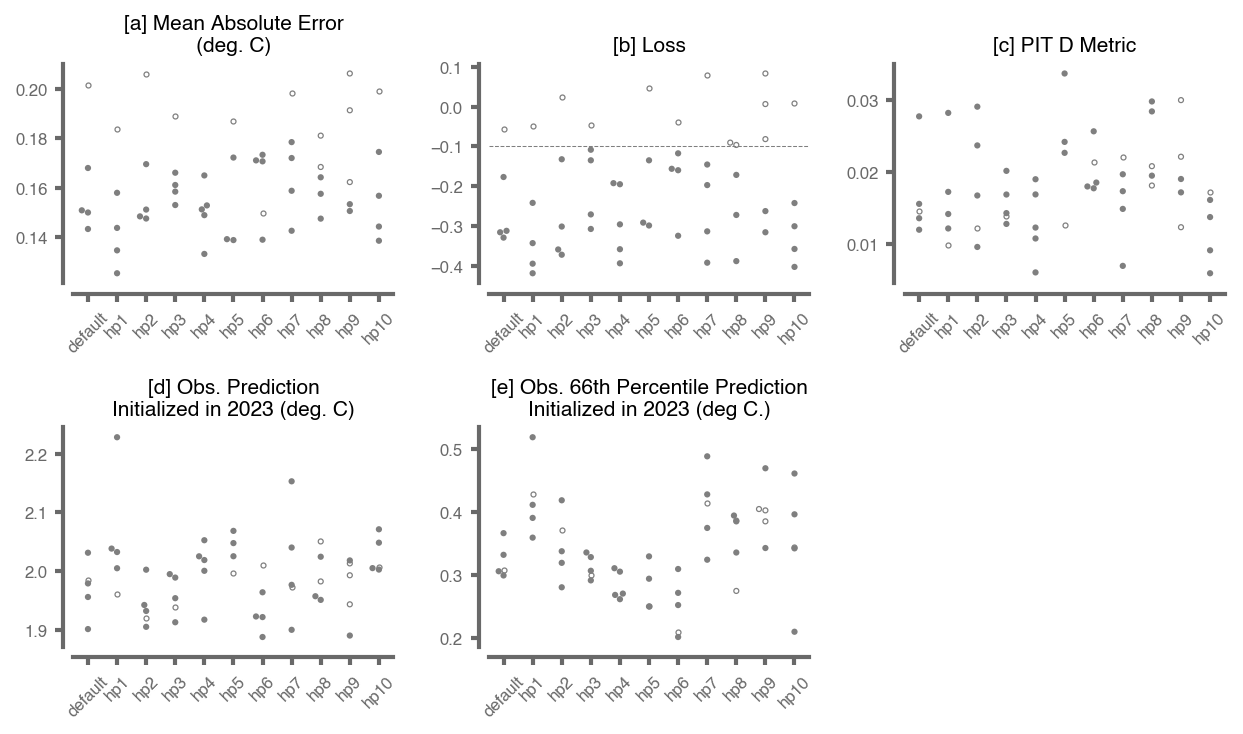

In [4]:
import seaborn as sns

warnings.filterwarnings("ignore")

exp_list = (
    "exp403",
    "exp001",
    "exp002",
    "exp003",
    "exp004",
    "exp005",
    "exp006",
    "exp007",
    "exp008",
    "exp009",
    "exp010",
)

df_plot = df_metrics[df_metrics["exp_name"].isin(exp_list)]
df_plot_loss = df_metrics_loss[df_metrics_loss["exp_name"].isin(exp_list)]

df_plot = df_plot[df_plot["rng_seed"].isin((314, 159, 265, 358, 979))]
df_plot_loss = df_plot_loss[df_plot_loss["rng_seed"].isin((314, 159, 265, 358, 979))]

labels = ["default", "hp1", "hp2", "hp3", "hp4", "hp5", "hp6", "hp7", "hp8", "hp9", "hp10"]
# labels = df_plot["exp_name"].unique()

palette = (
    "tab:gray",
    "tab:purple",
    "tab:orange",
    "tab:blue",
    "tab:red",
    "tab:green",
    "tab:pink",
    "tab:brown",
    "tab:olive",
    "gold",
)
clr_order = np.zeros((len(labels)), dtype="int32")
size = 3.0
FS = 10

fig, axs = plt.subplots(2, 3, figsize=(8.4, 5.0))
axs = axs.flatten()

# ------------------------------------------
ax = axs[0]
plots.format_spines(ax)

sns.swarmplot(
    x="exp_name",
    y="error_test",
    palette=np.array(palette)[clr_order],
    data=df_plot,
    size=size,
    ax=ax,
)
sns.swarmplot(
    x="exp_name",
    y="error_test",
    palette=np.array(palette)[clr_order],
    data=df_plot_loss,
    size=size,
    ax=ax,
    marker="$\\circ$",
)
ax.set_title("[a] Mean Absolute Error\n(deg. C)", fontsize=FS)
# ax.set_ylim(0.0, None)
ax.tick_params(axis="x", labelrotation=45, labelsize=FS * 0.8)
ax.tick_params(axis="y", labelsize=FS * 0.8)
ax.set_xlabel("", fontsize=FS)
ax.set_ylabel("", fontsize=FS)
ax.set_xticklabels(labels)

# ------------------------------------------
ax = axs[1]
plots.format_spines(ax)
sns.swarmplot(
    x="exp_name",
    y="loss_test",
    palette=np.array(palette)[clr_order],
    data=df_plot,
    size=size,
    ax=ax,
)
sns.swarmplot(
    x="exp_name",
    y="loss_test",
    palette=np.array(palette)[clr_order],
    data=df_plot_loss,
    size=size,
    ax=ax,
    marker="$\\circ$",
)
ax.set_title("[b] Loss", fontsize=FS)
# ax.set_ylim(None, 0.05)
ax.tick_params(axis="x", labelrotation=45, labelsize=FS * 0.8)
ax.tick_params(axis="y", labelsize=FS * 0.8)
ax.set_xlabel("", fontsize=FS)
ax.set_ylabel("", fontsize=FS)
ax.set_xticklabels(labels)
ax.axhline(y=LOSS_THRESHOLD, linewidth=0.5, alpha=0.5, color="k", linestyle="--")

# ------------------------------------------
ax = axs[2]
plots.format_spines(ax)
sns.swarmplot(
    x="exp_name",
    y="d_valtest",
    palette=np.array(palette)[clr_order],
    data=df_plot,
    size=size,
    ax=ax,
)
sns.swarmplot(
    x="exp_name",
    y="d_valtest",
    palette=np.array(palette)[clr_order],
    data=df_plot_loss,
    size=size,
    ax=ax,
    marker="$\circ$",
)
ax.set_title("[c] PIT D Metric", fontsize=FS)
# ax.set_ylim(0, None)
# ax.set_xticks(np.arange(0,5), fontsize=FS*0.8, rotation=45)
ax.tick_params(axis="x", labelrotation=45, labelsize=FS * 0.8)
ax.tick_params(axis="y", labelsize=FS * 0.8)
ax.set_xlabel("", fontsize=FS)
ax.set_ylabel("", fontsize=FS)
ax.set_xticklabels(labels)

# ------------------------------------------
ax = axs[3]
plots.format_spines(ax)
sns.swarmplot(
    x="exp_name",
    y="obs_2023_mean",
    palette=np.array(palette)[clr_order],
    data=df_plot,
    size=size,
    ax=ax,
)
sns.swarmplot(
    x="exp_name",
    y="obs_2023_mean",
    palette=np.array(palette)[clr_order],
    data=df_plot_loss,
    size=size,
    ax=ax,
    marker="$\circ$",
)
ax.set_title("[d] Obs. Prediction\nInitialized in 2023 (deg. C)", fontsize=FS)
# ax.set_ylim(2020, 2070)
ax.tick_params(axis="x", labelrotation=45, labelsize=FS * 0.8)
ax.tick_params(axis="y", labelsize=FS * 0.8)
ax.set_ylabel("", fontsize=FS)
ax.set_xlabel("", fontsize=FS)
ax.set_xticklabels(labels)

# ------------------------------------------
ax = axs[4]
plots.format_spines(ax)
sns.swarmplot(
    x="exp_name",
    y="obs_2023_width",
    palette=np.array(palette)[clr_order],
    data=df_plot,
    size=size,
    ax=ax,
)
sns.swarmplot(
    x="exp_name",
    y="obs_2023_width",
    palette=np.array(palette)[clr_order],
    data=df_plot_loss,
    size=size,
    ax=ax,
    marker="$\circ$",
)
ax.set_title(
    "[e] Obs. 66th Percentile Prediction\nInitialized in 2023 (deg C.)", fontsize=FS
)
# ax.set_ylim(0.0, 20.0)
ax.tick_params(axis="x", labelrotation=45, labelsize=FS * 0.8)
ax.tick_params(axis="y", labelsize=FS * 0.8)
ax.set_ylabel("", fontsize=FS)
ax.set_xlabel("", fontsize=FS)
ax.set_xticklabels(labels)

# ------------------------------------------
axs[5].remove()

plt.tight_layout()

plots.savefig(
    config["figure_dir"] + "release/hyperparameter_sweep_panels",
    fig_format=(".png", ".pdf"),
    dpi=config["fig_dpi"],
)

plt.show()

In [5]:
# raise ValueError

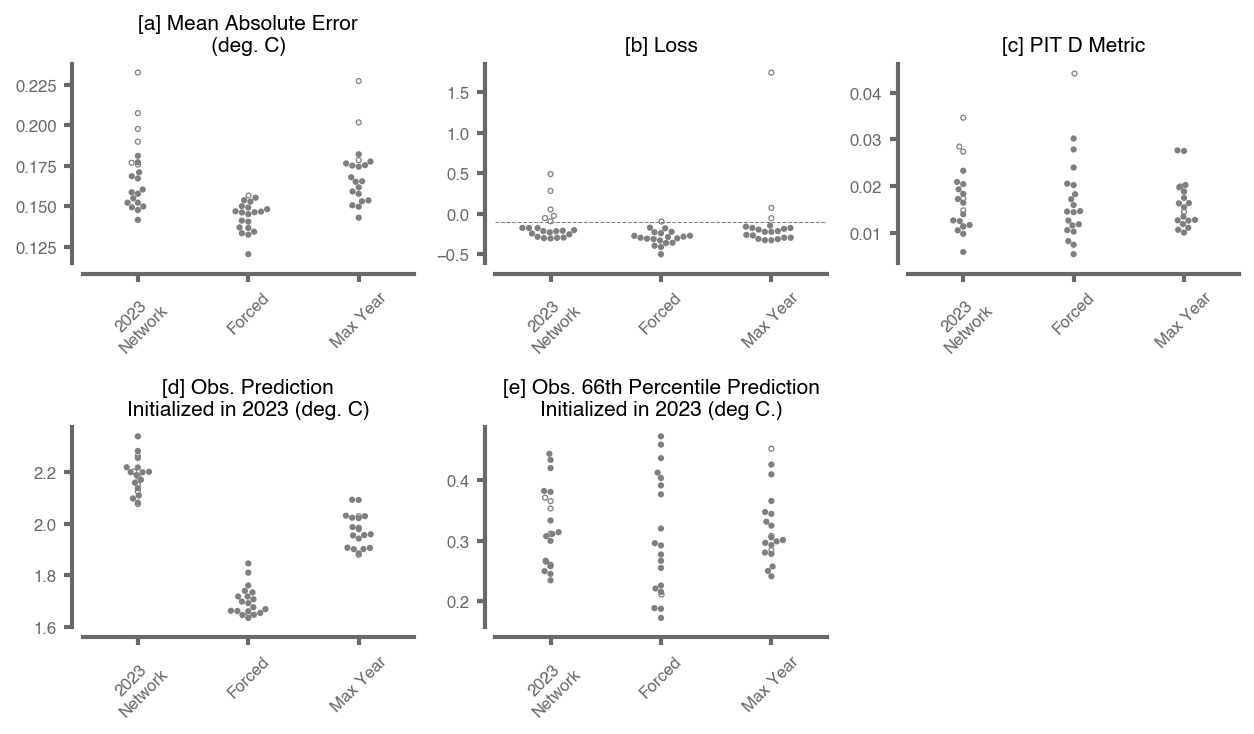

In [6]:
import seaborn as sns

warnings.filterwarnings("ignore")

exp_list = ("exp402", "exp403", "exp401")
# exp_list = ("exp405", "exp004", "exp406")
df_plot = df_metrics[df_metrics["exp_name"].isin(exp_list)]
df_plot_loss = df_metrics_loss[df_metrics_loss["exp_name"].isin(exp_list)]
# labels = df_plot["exp_name"].unique()
labels = ("2023\nNetwork", "Forced", "Max Year")

palette = (
    "tab:gray",
    "tab:purple",
    "tab:orange",
    "tab:blue",
    "tab:red",
    "tab:green",
    "tab:pink",
    "tab:brown",
    "tab:olive",
    "gold",
)
clr_order = np.zeros((len(labels)), dtype="int32")
size = 3.0
FS = 10

fig, axs = plt.subplots(2, 3, figsize=(8.4, 5.0))
axs = axs.flatten()

# ------------------------------------------
ax = axs[0]
plots.format_spines(ax)

sns.swarmplot(
    x="exp_name",
    y="error_test",
    palette=np.array(palette)[clr_order],
    data=df_plot,
    size=size,
    ax=ax,
)
sns.swarmplot(
    x="exp_name",
    y="error_test",
    palette=np.array(palette)[clr_order],
    data=df_plot_loss,
    size=size,
    ax=ax,
    marker="$\\circ$",
)
ax.set_title("[a] Mean Absolute Error\n(deg. C)", fontsize=FS)
# ax.set_ylim(0.0, None)
ax.tick_params(axis="x", labelrotation=45, labelsize=FS * 0.8)
ax.tick_params(axis="y", labelsize=FS * 0.8)
ax.set_xlabel("", fontsize=FS)
ax.set_ylabel("", fontsize=FS)
ax.set_xticklabels(labels)

# ------------------------------------------
ax = axs[1]
plots.format_spines(ax)
sns.swarmplot(
    x="exp_name",
    y="loss_test",
    palette=np.array(palette)[clr_order],
    data=df_plot,
    size=size,
    ax=ax,
)
sns.swarmplot(
    x="exp_name",
    y="loss_test",
    palette=np.array(palette)[clr_order],
    data=df_plot_loss,
    size=size,
    ax=ax,
    marker="$\\circ$",
)
ax.set_title("[b] Loss", fontsize=FS)
# ax.set_ylim(None, 0.05)
ax.tick_params(axis="x", labelrotation=45, labelsize=FS * 0.8)
ax.tick_params(axis="y", labelsize=FS * 0.8)
ax.set_xlabel("", fontsize=FS)
ax.set_ylabel("", fontsize=FS)
ax.set_xticklabels(labels)
ax.axhline(y=LOSS_THRESHOLD, linewidth=0.5, alpha=0.5, color="k", linestyle="--")

# ------------------------------------------
ax = axs[2]
plots.format_spines(ax)
sns.swarmplot(
    x="exp_name",
    y="d_valtest",
    palette=np.array(palette)[clr_order],
    data=df_plot,
    size=size,
    ax=ax,
)
sns.swarmplot(
    x="exp_name",
    y="d_valtest",
    palette=np.array(palette)[clr_order],
    data=df_plot_loss,
    size=size,
    ax=ax,
    marker="$\circ$",
)
ax.set_title("[c] PIT D Metric", fontsize=FS)
# ax.set_ylim(0, None)
# ax.set_xticks(np.arange(0,5), fontsize=FS*0.8, rotation=45)
ax.tick_params(axis="x", labelrotation=45, labelsize=FS * 0.8)
ax.tick_params(axis="y", labelsize=FS * 0.8)
ax.set_xlabel("", fontsize=FS)
ax.set_ylabel("", fontsize=FS)
ax.set_xticklabels(labels)

# ------------------------------------------
ax = axs[3]
plots.format_spines(ax)
sns.swarmplot(
    x="exp_name",
    y="obs_2023_mean",
    palette=np.array(palette)[clr_order],
    data=df_plot,
    size=size,
    ax=ax,
)
sns.swarmplot(
    x="exp_name",
    y="obs_2023_mean",
    palette=np.array(palette)[clr_order],
    data=df_plot_loss,
    size=size,
    ax=ax,
    marker="$\circ$",
)
ax.set_title("[d] Obs. Prediction\nInitialized in 2023 (deg. C)", fontsize=FS)
# ax.set_ylim(2020, 2070)
ax.tick_params(axis="x", labelrotation=45, labelsize=FS * 0.8)
ax.tick_params(axis="y", labelsize=FS * 0.8)
ax.set_ylabel("", fontsize=FS)
ax.set_xlabel("", fontsize=FS)
ax.set_xticklabels(labels)

# ------------------------------------------
ax = axs[4]
plots.format_spines(ax)
sns.swarmplot(
    x="exp_name",
    y="obs_2023_width",
    palette=np.array(palette)[clr_order],
    data=df_plot,
    size=size,
    ax=ax,
)
sns.swarmplot(
    x="exp_name",
    y="obs_2023_width",
    palette=np.array(palette)[clr_order],
    data=df_plot_loss,
    size=size,
    ax=ax,
    marker="$\circ$",
)
ax.set_title(
    "[e] Obs. 66th Percentile Prediction\nInitialized in 2023 (deg C.)", fontsize=FS
)
# ax.set_ylim(0.0, 20.0)
ax.tick_params(axis="x", labelrotation=45, labelsize=FS * 0.8)
ax.tick_params(axis="y", labelsize=FS * 0.8)
ax.set_ylabel("", fontsize=FS)
ax.set_xlabel("", fontsize=FS)
ax.set_xticklabels(labels)

# ------------------------------------------
axs[5].remove()

plt.tight_layout()

plots.savefig(
    config["figure_dir"] + "release/main_experiments_panels",
    fig_format=(".png", ".pdf"),
    dpi=config["fig_dpi"],
)

plt.show()

In [7]:
# raise ValueError()

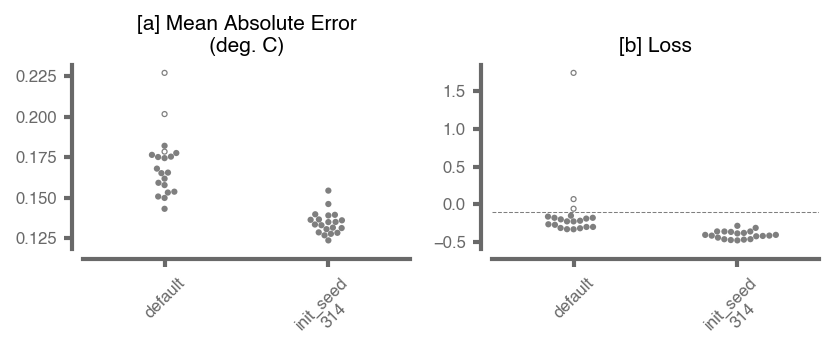

In [8]:
import seaborn as sns

warnings.filterwarnings("ignore")

exp_list = ("exp403", "exp081")
# exp_list = ("exp403", "exp080", "exp081")
# exp_list = ("exp004", "exp091")
df_plot = df_metrics[df_metrics["exp_name"].isin(exp_list)]
df_plot_loss = df_metrics_loss[df_metrics_loss["exp_name"].isin(exp_list)]
labels = df_plot["exp_name"].unique()
labels = ("default", "init_seed\n314")

palette = ("tab:gray",)
clr_order = np.zeros((len(labels)), dtype="int32")
size = 3.0
FS = 10

fig, axs = plt.subplots(1, 2, figsize=(8.4 / 3 * 2, 5.0 / 2))
axs = axs.flatten()

# ------------------------------------------
ax = axs[0]
plots.format_spines(ax)
sns.swarmplot(
    x="exp_name",
    y="error_test",
    palette=np.array(palette)[clr_order],
    data=df_plot,
    size=size,
    ax=ax,
)
sns.swarmplot(
    x="exp_name",
    y="error_test",
    palette=np.array(palette)[clr_order],
    data=df_plot_loss,
    size=size,
    ax=ax,
    marker="$\\circ$",
)
ax.set_title("[a] Mean Absolute Error\n(deg. C)", fontsize=FS)
# ax.set_ylim(0.0, None)
ax.tick_params(axis="x", labelrotation=45, labelsize=FS * 0.8)
ax.tick_params(axis="y", labelsize=FS * 0.8)
ax.set_xlabel("", fontsize=FS)
ax.set_ylabel("", fontsize=FS)
ax.set_xticklabels(labels)

# ------------------------------------------
ax = axs[1]
plots.format_spines(ax)
sns.swarmplot(
    x="exp_name",
    y="loss_test",
    palette=np.array(palette)[clr_order],
    data=df_plot,
    size=size,
    ax=ax,
)
sns.swarmplot(
    x="exp_name",
    y="loss_test",
    palette=np.array(palette)[clr_order],
    data=df_plot_loss,
    size=size,
    ax=ax,
    marker="$\\circ$",
)
ax.set_title("[b] Loss", fontsize=FS)
# ax.set_ylim(None, -.1)
ax.tick_params(axis="x", labelrotation=45, labelsize=FS * 0.8)
ax.tick_params(axis="y", labelsize=FS * 0.8)
ax.set_xlabel("", fontsize=FS)
ax.set_ylabel("", fontsize=FS)
ax.set_xticklabels(labels)
ax.axhline(y=LOSS_THRESHOLD, linewidth=0.5, alpha=0.5, color="k", linestyle="--")


plt.tight_layout()

plots.savefig(
    config["figure_dir"] + "release/initialization_seed_panels",
    fig_format=(".png", ".pdf"),
    dpi=config["fig_dpi"],
)

plt.show()

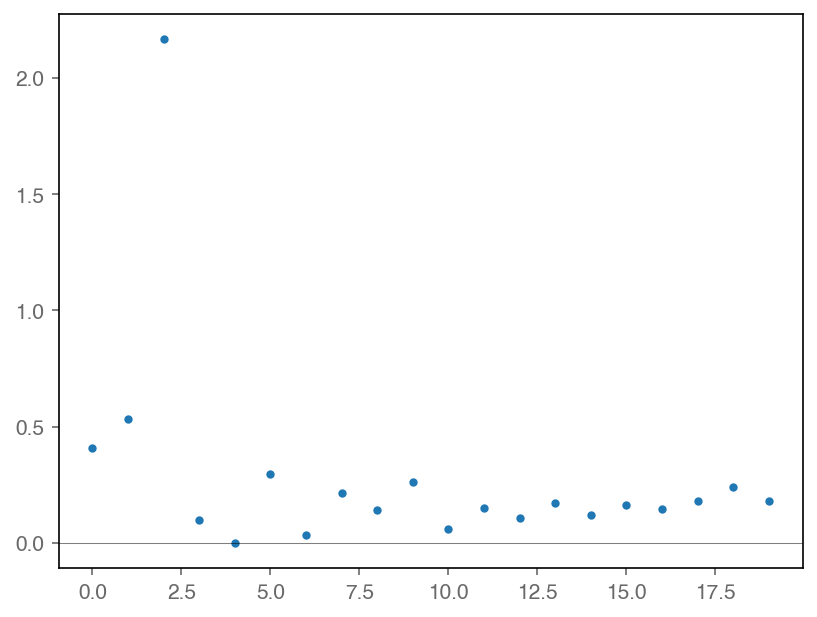

In [9]:
metric = "loss_test"

df = pd.concat((df_metrics_loss, df_metrics), axis=0)
x = df[(df["exp_name"] == "exp403")][metric].to_numpy()
y = df[(df["exp_name"] == "exp081")][metric].to_numpy()

plt.plot(x - y, ".")
plt.axhline(y=0, color="k", linewidth=0.5, alpha=0.5)